In [1]:
# SOURCES
#https://www.kaggle.com/awsaf49/vinbigdata-cxr-ad-yolov5-14-class
#https://www.kaggle.com/ultralytics/yolov5
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt pycocotools # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.1 CPU


In [2]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
#from tqdm.notebook 
from tqdm import tqdm
import seaborn as sns

In [3]:
data_path = '/Volumes/Samsung_SSD'

In [4]:
train_df = pd.read_csv(f'{data_path}/train.csv')
train_df.head()

# https://www.kaggle.com/awsaf49/vinbigdata-1024-image-dataset
train_df['image_path'] = f'{data_path}/vinbigdata-1024-images/train/'+train_df.image_id+'.png'
train_df.head()

train_df = train_df[train_df.class_id!=14].reset_index(drop = True)

In [5]:
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==0].image_path.unique())
train_files += list(train_df[train_df.fold!=0].image_path.unique())
len(train_files), len(val_files)

os.makedirs(f'{data_path}/vinbigdata-1024-images/labels/train', exist_ok = True)
os.makedirs(f'{data_path}/vinbigdata-1024-images/labels/val', exist_ok = True)
os.makedirs(f'{data_path}/vinbigdata-1024-images/images/train', exist_ok = True)
os.makedirs(f'{data_path}/vinbigdata-1024-images/images/val', exist_ok = True)
label_dir = f'{data_path}/vinbigdata-yolo-labels-dataset/labels'
for file in tqdm(train_files):
    shutil.copy(file, f'{data_path}/vinbigdata-1024-images/images/train')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), f'{data_path}/vinbigdata-1024-images/labels/train')
    
for file in tqdm(val_files):
    shutil.copy(file, f'{data_path}/vinbigdata-1024-images/images/val')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), f'{data_path}/vinbigdata-1024-images/labels/val')
    
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

100%|██████████| 879/879 [00:04<00:00, 188.03it/s]


['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='data/images/', update=False, view_img=False, weights=['yolov5s.pt'])
Using torch 1.7.1 CPU

Fusing layers... 
Model Summary: 232 layers, 7459581 parameters, 0 gradients, 17.5 GFLOPS
image 1/2 /Users/pc/bin/pyenv/xray/notebooks/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 buss, 1 skateboards, Done. (0.322s)
image 2/2 /Users/pc/bin/pyenv/xray/notebooks/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, Done. (0.236s)
Results saved to runs/detect/exp6
Done. (0.648s)


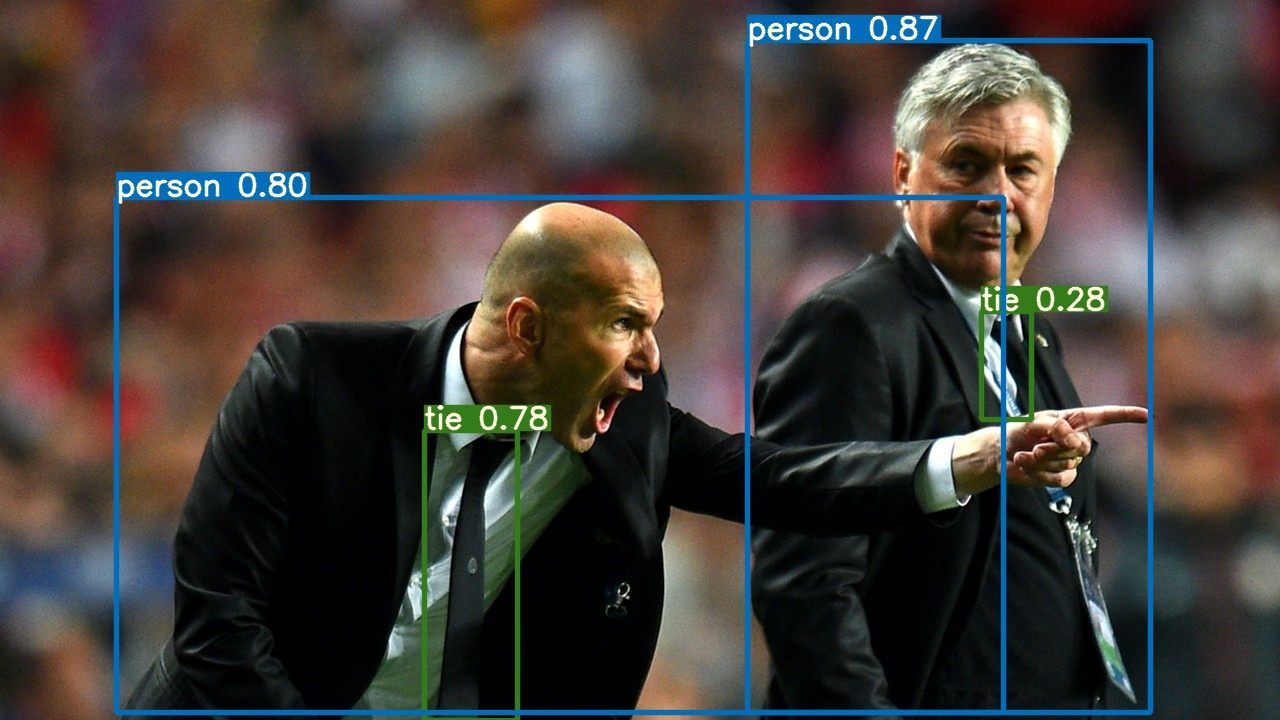

In [6]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=600)

In [7]:
from os import listdir
from os.path import isfile, join
import yaml

cwd = data_path

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob(f'{data_path}/vinbigdata-1024-images/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob(f'{data_path}/vinbigdata-1024-images/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 14,
    names = classes
    )

with open(join( cwd , 'vinbigdata.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'vinbigdata.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: /Volumes/Samsung_SSD/train.txt
val: /Volumes/Samsung_SSD/val.txt



In [11]:
# !WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 3 --data coco128.yaml --weights yolov5s.pt --nosave --cache 
!WANDB_MODE="dryrun" python train.py --workers 0 --img 512 --batch 16 --epochs 5 --data /Volumes/Samsung_SSD/vinbigdata.yaml --weights yolov5s.pt --cache

Using torch 1.7.1 CPU

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='', data='/Volumes/Samsung_SSD/vinbigdata.yaml', device='', epochs=5, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[512, 512], local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/exp6', single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5s.pt', workers=0, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0